In [1]:
# These libraries are available in the Python 3 kernel
import pandas as pd
import numpy as np
from os.path import exists

# These libraries are not available in the Python 3 kernel but are in py-gordon_1_0_0
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Introduction

The radiative forcing of some feature of the climate is the effect of that feature in its present state on Earth’s surface’s energy flux relative to the feature’s equilibrium state. As regards aerosols, they occur in higher concentrations in the atmosphere today compared to roughly before the industrial revolution and have a noticeable cooling effect - a negative radiative forcing. This is in contrast to the warming effect of greenhouse gases released by similar human intervention. It would be useful to better estimate the radiative forcing of atmospheric aerosol to better forecast its cooling effects on the climate in the long run, for example.

We consider two types of datasets, one type simulated from a complex climate model and another type from a number aircraft missions (Ex: NASA's ORACLES missions) observing actual aerosol-related features around the globe. The simulated climate data are obtained from a sample of model variants chosen from a large parameter space. We will interpolate levels of aerosol-related observables for different parameter combinations. Then, having made our surface of best guesses to these quantities, we will estimate our uncertainty in those guesses. We will ultimately estimate the radiative forcing due to aerosols by comparing our observations (Ex: as measured on the ORACLES missions) with the simulated observables from an equilibrium state.' Previously, work has been done to i) constrain the parameter space using an implausibility metric and to ii) estimate uncertainty in instruments by making some assumptions about the different sources of error. For this project, we will attempt to make statistically more rigorous these steps.

# Observation files

The ORACLES missions took place between 2016 and 2019 largely in the SE Atlantic for the reason that the aerosol optical depths (AOD) in that region are among the highest levels on the planet due to biomass burning on the continent which far eclipses that on other contintents. The aircraft used for the missions were equipped with a large suite of instruments, and our datasets from these missions feature the readings from these instruments in a high time resolution (once per minute?) as well as the spatiotemporal origin of the measurements (that is, the flight path). On the ORACLES mission page, the mounted instruments used for ORACLES 1, 2, and 3 are summarized. See the Data Archive on https://espo.nasa.gov/ORACLES.

As far as I can see, our server includes 16 mission files from revision 18 and 19 from revision 26. I take it that these revision numbers refer to different corrections of the data in the files themselves, and so a revision 26 file would be preferred over a revision 18 file if there is a coincidence. These are netCDF files. Additionally, there are two "test" files, which are .txt files.

Below, we list the URLs at which these files may be accessed as well as the number of variables and the lengths of the "Longitude" variable in each file. Each of the R18 files has only 7 variables: 'Longitude', 'time', 'time_bnds', 'hour', 'minute', 'Latitude', and 'MSL_GPS_Altitude'. Apparently these files don't feature any atmospheric measurements! Meanwhile, the R26 files have anywhere from 127 variables (from 4 September 2017) to 340 variables (from 18 August 2017). Many of these variables are obscure readings from instruments on board the aircraft, and we will attempt to classify them later on.

The length of "Longitude" suggests something about either the time resolution of the time series represented by (most of) the variables in each file or the duration of the flight. As is clear by the list, the R18 files have a much shorter length than the R26 ones; the maximum length among the R18 ones is 570 while the minimum length among the R26 ones is 6666. Combining these differences between the datasets, I am inclined to think that the R18 files are not reports of flights for scientific purposes but may instead be reports of flights for logistic purposes, i.e. traveling to and from study locations. Either way, these files are not interesting to us because they do not feature atmospheric measurements.

In [2]:
# List the observation data files
obs_files_list = c3.FileSystem.inst().listFiles("azure://aircraft-observations/").files

obs_files_url = []
for file in obs_files_list:
    # To read the urls
    obs_files_url.append(file.url)
    print("URL:" + file.url)
    # To get a sense of size
    if not file.url.endswith(".txt") and not file.url.endswith(".csv") and not file.url.endswith(".na"):
        sample = c3.NetCDFUtil.openFile(file.url)        
        print("# variables:" + str(len(sample.variables.keys())))
        #print("Length:" + str(len(sample["Longitude"][:])) + "\n")
        if file.url.endswith('data.nc'):
            print(sample.variables['nitrate_calc'])

URL:azure://aircraft-observations/ATom_60s_aerosol_data.nc
# variables:87
<class 'netCDF4._netCDF4.Variable'>
float32 nitrate_calc(DateTime_UTC)
    long_name: nitrate_mass_concentration_from_size_distributions_STP
    units: ug_cm^-3
    _FillValue: -999.0
    scale_factor: 1
    add_offset: 0
    coordinates: time latitude longitude
unlimited dimensions: 
current shape = (24638,)
filling on
URL:azure://aircraft-observations/ATom_aerosol_profiles.nc
# variables:83
URL:azure://aircraft-observations/CLARIFY/c028_exscalabar_rb_ext_abs_v03.csv
URL:azure://aircraft-observations/CLARIFY/c029_exscalabar_rb_ext_abs_v03.csv
URL:azure://aircraft-observations/CLARIFY/c030_exscalabar_rb_ext_abs_v03.csv
URL:azure://aircraft-observations/CLARIFY/c031_exscalabar_rb_ext_abs_v03.csv
URL:azure://aircraft-observations/CLARIFY/c031_exscalabar_rb_ext_abs_v04.csv
URL:azure://aircraft-observations/CLARIFY/c032_exscalabar_rb_ext_abs_v03.csv
URL:azure://aircraft-observations/CLARIFY/c033_exscalabar_rb_ext_abs

# variables:15
URL:azure://aircraft-observations/MER10_DC8_ATom-2.nc
# variables:18
URL:azure://aircraft-observations/MER10_DC8_ATom-3.nc
# variables:16
URL:azure://aircraft-observations/MER10_DC8_ATom-4.nc
# variables:18
URL:azure://aircraft-observations/min_mrg1_P3_20170809_R18.nc
# variables:7
URL:azure://aircraft-observations/min_mrg1_P3_20170812_R18.nc
# variables:7
URL:azure://aircraft-observations/min_mrg1_P3_20170813_R18.nc
# variables:7
URL:azure://aircraft-observations/min_mrg1_P3_20170815_R18.nc
# variables:7
URL:azure://aircraft-observations/min_mrg1_P3_20170817_R18.nc
# variables:7
URL:azure://aircraft-observations/min_mrg1_P3_20170818_R18.nc
# variables:7
URL:azure://aircraft-observations/min_mrg1_P3_20170819_R18.nc
# variables:7
URL:azure://aircraft-observations/min_mrg1_P3_20170821_R18.nc
# variables:7
URL:azure://aircraft-observations/min_mrg1_P3_20170824_R18.nc
# variables:7
URL:azure://aircraft-observations/min_mrg1_P3_20170826_R18.nc
# variables:7
URL:azure://aircra

## Observational variables

The features of these files fall into many families. Broadly speaking, there are variables describing the following:

i) "When" (i.e. time of measurement, day of the year)

ii) "Where," including general (i.e. coordinates, various altitude measurements) and specific (i.e. ground speed, drift and pitch angle, solar zenith angle)

iii) derived parameters, which begin with the acronym "WINDS"  (i.e. WINDS_Pitch_deg)

iv) the state of the aircraft (i.e. cabin pressure, system radar altitude)

v) the weather (i.e. dew point, wind speed, relative humidity)

vi) aerosol quantities measured by acronymized instruments including a TSI 3563 integrating nephelometer (i.e. TSI_Scat_Tot) and a Radiance Research M903 nephelometer (i.e. RRDry_Scat540_Tot)

vii) aerosol quantities whose source is not implicit (i.e. CNgt10, rBC_massConc (a measurement of incandescence from the refractory black carbon (rBC)))

viii) aerosol optical depth (i.e. qual_flag, amass_acr, AOD_angstrom_470_865)

ix) clouds measured by acronymized instruments including a cloud and aerosol spectrometer (i.e. CASConcCH), a cloud droplet probe (i.e. CDP_CH), a high-volume precipitation spectrometer (i.e. HVPS3H_CH), a PCASP-SPP200 aerosol spectrometer probe (i.e. SPP200_CH), and a King Probe (i.e. King_LWC_ad)

x) clouds generally, but without an obvious way to classify or interpret further including about the TwoDS Vertical Normalized Particle Concentration (i.e. TWODSV_CH1), the RSP2 Water Cloud Retrievals (i.e. RSP2-WTRCLD_CTH_stereo), the Counterflow Virtual Impactor (i.e. cvi_lwc), and others (i.e. COD, REF, LWP)

xi) water generally (i.e. h2o_tot1, dD_tot1)

xii) adjusted, smoothed, or converted measurements (i.e. TSI_Scat_Tot_ATP, SSAsm60s, stdPT-to-AMB_Conversion)

xiii) summary variables prefixed with "UND-Summary-"

xiv) unknown time series (i.e. CVI_Mask, Big_Leak_Corr)

xv) unknown non-time series (i.e. GITUHSASdiameter, SSFRwavelength, UHSASdlogd)

Of these, the most important categories are i), ii), v), vi), vii), viii), and ix), and some from xiv). Some of these categories were gleaned from examples of variables' long names as stored in the netCDF files. Others are guesses based on searches for acronyms in the atmospheric sciences. All of these categories are represented in the 18 August 2017 dataset. See below a complete list of the set differences of variables from shorter lists with the list from this date.

## Variables in smaller files but not in the biggest

In [530]:
# This is the file with the longest list of variables
sample_biggest = c3.NetCDFUtil.openFile(obs_files_url[24])

for i in range(16, 16 + 19):
    # Compare the longest list with each other list
    if i != 24:    
        sample_smaller = c3.NetCDFUtil.openFile(obs_files_url[i])

        # Inspect the short list of those variables included in each other list but not in the longest
        print("URL:" + obs_files_url[i])
        print("Var list set diff:" + str(np.setdiff1d(list(sample_smaller.variables.keys()),
                                                      list(sample_biggest.variables.keys()))) + "\n")
        print("Var")

URL:azure://aircraft-observations/mrg1_P3_20170801_R26.nc
Var list set diff:['CIPH_EffRad' 'MSLAltitude' 'Nt_CIP_H' 'RadarAltitu' 'StaticPress'
 'StaticTemp' 'TotalTemp']

URL:azure://aircraft-observations/mrg1_P3_20170802_R26.nc
Var list set diff:['CIPH_EffRad' 'MSLAltitude' 'Nt_CIP_H' 'RadarAltitu' 'StaticPress'
 'StaticTemp' 'TotalTemp']

URL:azure://aircraft-observations/mrg1_P3_20170807_R26.nc
Var list set diff:['CIPH_EffRad' 'MSLAltitude' 'Nt_CIP_H' 'RadarAltitu' 'StaticPress'
 'StaticTemp' 'TotalTemp']

URL:azure://aircraft-observations/mrg1_P3_20170809_R26.nc
Var list set diff:['CIPH_EffRad' 'MSLAltitude' 'Nt_CIP_H' 'RadarAltitu' 'StaticPress'
 'StaticTemp' 'TotalTemp']

URL:azure://aircraft-observations/mrg1_P3_20170812_R26.nc
Var list set diff:['2DSH_Eff105' '2DSH_EffRad' '2DSH_Med105' '2DSH_MedVol' '2DSH_Median'
 '2DSH_MenDh' '2DSH_MenDhA' 'CCN_Number_Concentration'
 'CCN_Number_Concentration_STP' 'CCN_Supersaturation' 'MSLAltitude'
 'Nt2DSHGT105' 'Nt2DSHLT55' 'Nt2DSH_all' '

## Example: Revision 26 from 18 August 2017

We take a look at some flight paths below. The R26 flight on 18 August 2017 was around Ascension Island in the South Atlantic ocean. The R18 flight on 9 August 2017 appears to take place close to the island country of Sao Tome and Principe.

One view of the 18 August flight.

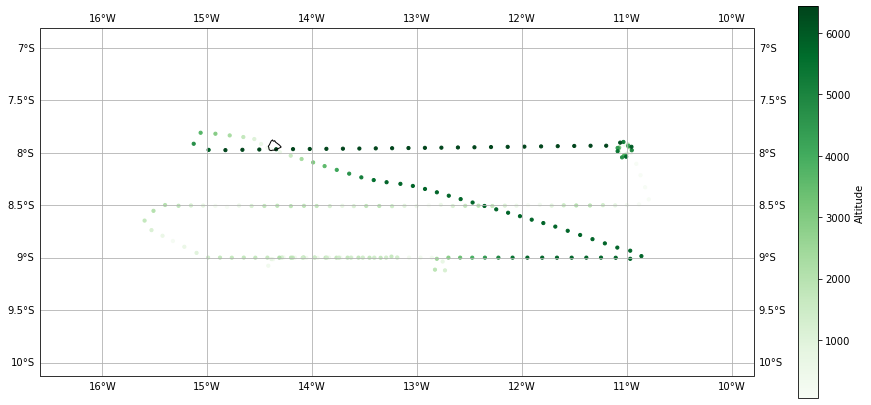

In [519]:
def plot_obs_flight_2d(url_index, rows_to_skip, revision=26):
    """
    Parameters
    
    url_index : integer, 0 to 34
        Which flight to plot - 0-15 are R18, 16-34 are R26
    rows_to_skip : integer
        If rows_to_skip = N, only plot every Nth point in the flight
    revision : integer, 18 or 26
    """
    sample = c3.NetCDFUtil.openFile(obs_files_url[url_index])
    # To read the variable names in this file, print(sample.variables.keys())

    if revision == 26:
        # These are the spatial variables
        spatial = pd.DataFrame({
            'lat' : sample["Latitude"][:],
            'lon' : sample["Longitude"][:],
            'alt_gps' : sample["GPS_Altitude"][:],
            'alt_press' : sample["Pressure_Altitude"][:],
            'alt_radar' : sample["Radar_Altitude"][:]},
            columns = ['lat', 'lon', 'alt_gps', 'alt_press', 'alt_radar']
        )
    elif revision == 18:
        spatial = pd.DataFrame({
            'lat' : sample["Latitude"][:],
            'lon' : sample["Longitude"][:],
            'alt_gps' : sample["MSL_GPS_Altitude"][:]},
            columns = ['lat', 'lon', 'alt_gps']
        )

    # Define the figure size and shape
    BBox = [spatial.lon.min()-1, spatial.lon.max()+1,      
             spatial.lat.min()-1, spatial.lat.max()+1]
    projection = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=[16, 12])

    # Draw island
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.coastlines()

    # Produce gridlines, coordinate labels
    ax.set_extent(BBox, ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, crs=projection)

    # Add points along flight path and color for altitude
    scatter = ax.scatter(spatial.lon[::rows_to_skip], spatial.lat[::rows_to_skip], zorder=1, alpha=1,
                         c=spatial.alt_gps[::rows_to_skip], cmap="Greens", s=10)
    cbar = plt.colorbar(scatter, shrink=0.6)
    cbar.set_label("Altitude")
    
    plt.show()

plot_obs_flight_2d(24, 100)

Another view of the 18 August flight. The black carbon mass concentration is depicted by its shade and the size of the haze along the path of the flight.

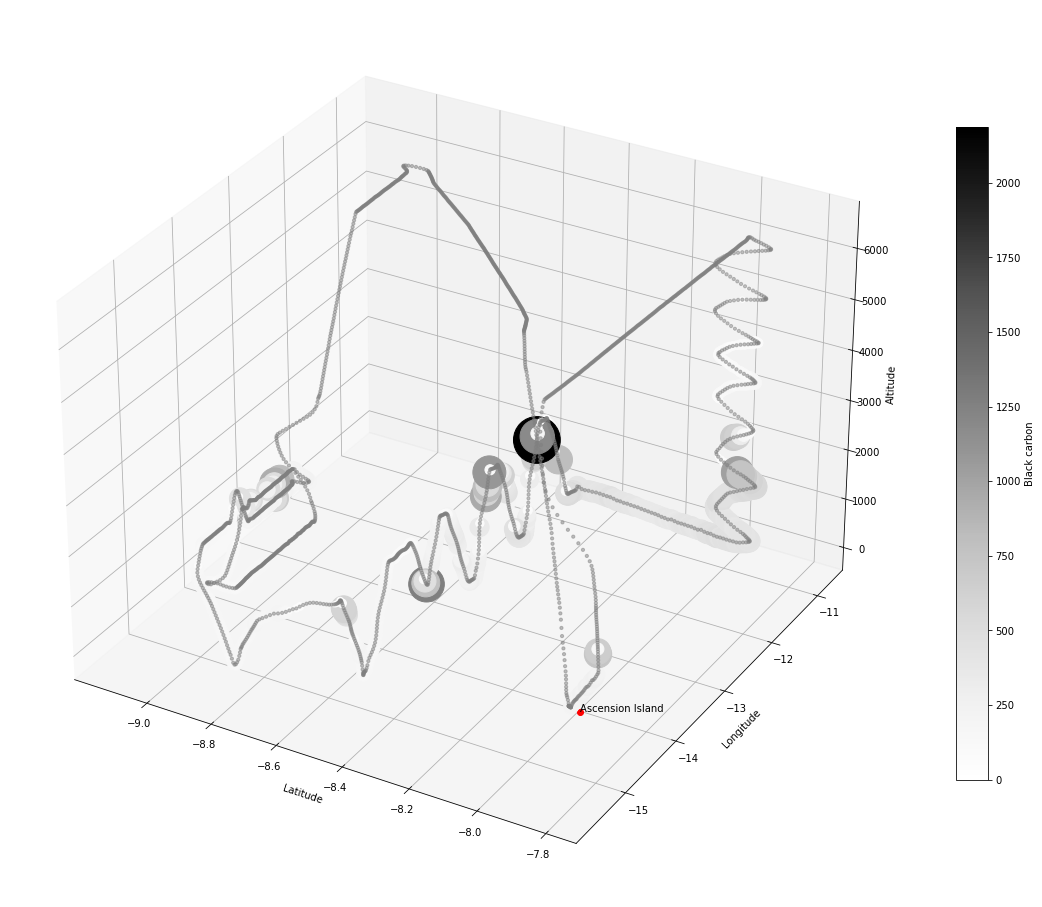

In [548]:
def plot_obs_flight_3d(url_index, rows_to_skip):
    """
    Parameters
    
    url_index : integer, 0 to 34
        Which flight to plot - 0-15 are R18, 16-34 are R26
    rows_to_skip : integer
        If rows_to_skip = N, only plot every Nth point in the flight
    """
    sample = c3.NetCDFUtil.openFile(obs_files_url[url_index])
    # To read the variable names in this file, print(sample.variables.keys())

    # These are the spatial variables
    spatial = pd.DataFrame({
        'lat' : sample["Latitude"][:],
        'lon' : sample["Longitude"][:],
        'alt_gps' : sample["GPS_Altitude"][:],
        'alt_press' : sample["Pressure_Altitude"][:],
        'alt_radar' : sample["Radar_Altitude"][:],
        # 'bc' : sample["SPP200_CH"][:]},
        'bc' : sample["rBC_massConc"][:]},
        columns = ['lat', 'lon', 'alt_gps', 'alt_press', 'alt_radar', 'bc']
    )

    fig = plt.figure(figsize=[20, 20])
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')
    
    ax.plot(-7.943368, -14.366035, 0, "ro")
    ax.text(-7.943368, -14.366035, 0, 'Ascension Island')

    scatter2 = ax.scatter(spatial.lat[::rows_to_skip], spatial.lon[::rows_to_skip], spatial.alt_gps[::rows_to_skip], alpha=1,
                         c=spatial.bc[::rows_to_skip], cmap="Greys", s=spatial.bc[::rows_to_skip])
    cbar = plt.colorbar(scatter2, shrink=0.6)
    cbar.set_label("Black carbon")
    # cbar.set_label("SPP200_CH")
    scatter = ax.scatter(spatial.lat[::rows_to_skip], spatial.lon[::rows_to_skip], spatial.alt_gps[::rows_to_skip], alpha=0.5, s=10,
                        c="Grey")
    plt.show()

plot_obs_flight_3d(24, 10)

## Example: Revision 26 from 28 August 2017

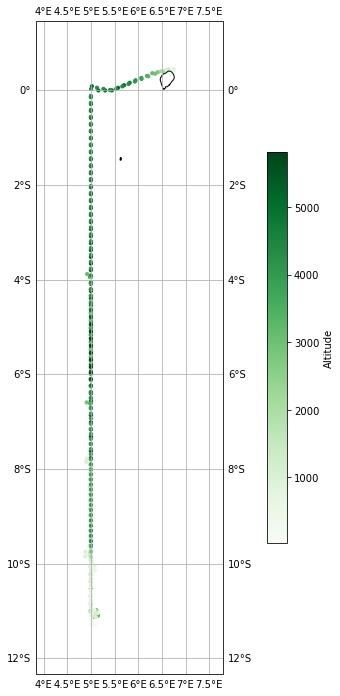

In [516]:
plot_obs_flight_2d(29, 100)

## Example: Revision 18 from 9 August 2017

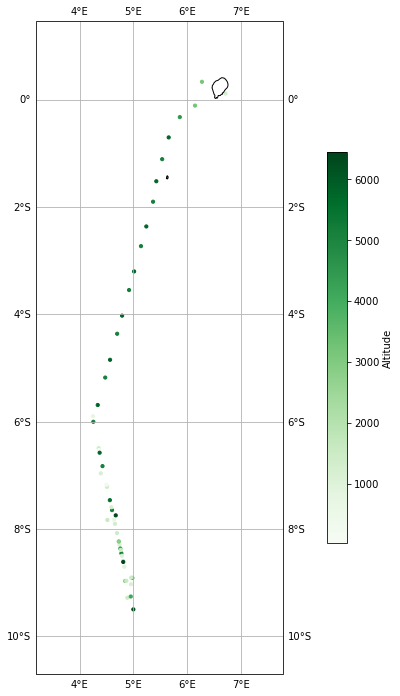

In [520]:
plot_obs_flight_2d(2, 10, 18)

# Simulation files

The simulations are being performed by a group at the University of Leeds. For each variant, a high-time and space-resolution, global simulation of a large number of climate variables is run. Then, for each aircraft tour, the simulated variable quantities coinciding with the tour route are collected are packaged in netCDF files which resemble the observational datasets.

There are 64 parameters on which the simulated data are set. From the 64-dimensional parameter space, 221 points are chosen to determine 221 different model variants. Here we peek at ten parameter values for the first ten variants in the ensemble.

In [499]:
# Obtain a comma-separated table of simulation ensemble members' parameter combinations
csv_table_metric = c3.SimulationModelParameters.fetch().objs.toJson()

# Save this table instead as a pandas dataframe (221 ensemble members x 64 parameters)
dfparams = pd.DataFrame(csv_table_metric)

# Peek at the dataframe with print(dfparams.head())

print(dfparams.head(10).iloc[:, 5 : 15])

   acure_bl_nuc  acure_ait_width  acure_cloud_ph  acure_carb_ff_ems  \
0      0.500000         0.650000        0.396000                1.0   
1      0.470000         0.500000        0.500000                1.0   
2      0.969888         0.083081        0.478474                1.0   
3      0.132847         0.445265        0.390414                1.0   
4      0.058261         0.630422        0.132292                1.0   
5      0.971227         0.209244        0.818772                1.0   
6      0.904936         0.894188        0.733200                1.0   
7      0.174272         0.101051        0.507135                1.0   
8      0.329976         0.399961        0.809334                1.0   
9      0.111914         0.927531        0.212178                1.0   

   acure_carb_ff_ems_eur  acure_carb_ff_ems_nam  acure_carb_ff_ems_chi  \
0               0.500000               0.500000               0.500000   
1               0.530000               0.470000               0.530000

## Simulated flights

In [522]:
# Define some metrics of interest

# mass_fraction_of_black_carbon_in_soluble_accumulation_mode_dry_aerosol_in_air
bcacc_metric = c3.SimpleMetric(id = "AverageMassBCacc_SimulationSample",
                               name = "AverageMassBCacc_SimulationSample",
                               description = "Calculates average of massBCacc for a given SimulationSample",
                               srcType = "SimulationSample",
                               path = "output",  # the timeseries is in the output field of SimSam
                               expression = "avg(avg(normalized.data.mass_BC_acc))")

# mass_fraction_of_particulate_organic_matter_in_soluble_accumulation_mode_dry_aerosol_in_air
ocacc_metric = c3.SimpleMetric(id = "AverageMassOCacc_SimulationSample",
                               name = "AverageMassOCacc_SimulationSample",
                               description = "Calculates average of massOCacc for a given SimulationSample",
                               srcType = "SimulationSample",
                               path = "output",  # the timeseries is in the output field of SimSam
                               expression = "avg(avg(normalized.data.mass_OC_acc))")

# mass_fraction_of_black_carbon_in_soluble_aitken_mode_dry_aerosol_in_air
bcait_metric = c3.SimpleMetric(id = "AverageMassBCait_SimulationSample",
                               name = "AverageMassBCait_SimulationSample",
                               description = "Calculates average of massBCait for a given SimulationSample",
                               srcType = "SimulationSample",
                               path = "output",  # the timeseries is in the output field of SimSam
                               expression = "avg(avg(normalized.data.mass_BC_Ait))")

# 
lon_metric = c3.SimpleMetric(id = "AverageLon_SimulationSample",
                             name = "AverageLon_SimulationSample",
                             description = "Calculates average of longitude for a given SimulationSample",
                             srcType = "SimulationSample",
                             path = "output",  # the timeseries is in the output field of SimSam
                             expression = "avg(avg(normalized.data.longitude))")

#
lat_metric = c3.SimpleMetric(id = "AverageLat_SimulationSample",
                             name = "AverageLat_SimulationSample",
                             description = "Calculates average of latitude for a given SimulationSample",
                             srcType = "SimulationSample",
                             path = "output",  # the timeseries is in the output field of SimSam
                             expression = "avg(avg(normalized.data.latitude))")

#
alt_metric = c3.SimpleMetric(id = "AverageAlt_SimulationSample",
                             name = "AverageAlt_SimulationSample",
                             description = "Calculates average of altitude for a given SimulationSample",
                             srcType = "SimulationSample",
                             path = "output",  # the timeseries is in the output field of SimSam
                             expression = "avg(avg(normalized.data.altitude))")

In [523]:
def evaluate_metrics(ensem_mem = 0,
                     start_time = "2017-08-18T00:00:00.000",
                     end_time = "2017-08-18T23:59:59.000",
                     time_int = "SECOND"):
    """
    For a particular model variant (i.e. ensemble member), access the simulated data for a selection of interesting
    variables within a given time frame and in a specified time interval
    
    Parameters
    
    ensem_mem : integer between 0 and 220
        Which model variant to sample
    start_time : datetime
        When to start evaluating the metric, e.g. "2017-08-18T00:00:00.000"
    end_time : datetime
        When to end evaluating the metric, e.g. "2017-08-18T23:59:59.000"
    time_int : string
        Time interval at which samples are desired, one of ['TEN_MINUTE', 'YEAR', 'DAY', 'MONTH', 'HOUR', 'MINUTE',
        'FIVE_MINUTE', 'HALF_HOUR', 'QUARTER_HOUR', 'SECOND']
    """

    # Specify the time frame and time interval of the data desired and the id of the sourceType (SimSam here)
    my_spec = c3.EvalMetricsSpec(
        # ID of ensemble member desired
        ids = ["EnsNo_1_SimNo_" + str(ensem_mem)],

        # The metric IDs desired from that ensemble member
        expressions = ["AverageMassBCacc_SimulationSample",
                       "AverageMassBCait_SimulationSample",
                       "AverageLon_SimulationSample",
                       "AverageLat_SimulationSample",
                       "AverageAlt_SimulationSample",
                       "AverageMassOCacc_SimulationSample"],

        # Time frame for sample (e.g. to specify when a flight occurred)
        start = start_time,
        end = end_time,

        # Time interval desired between simulated sample points (e.g. "SECOND", "MINUTE", "HOUR")
        interval = time_int)

    # evaluate the metric on the sourceType (SimSam)
    evalMetricsResultSS = c3.SimulationSample.evalMetricsWithMetadata(
        spec=my_spec,
        overrideMetrics=[bcacc_metric,
                         bcait_metric, 
                         lon_metric,
                         lat_metric,
                         alt_metric,
                         ocacc_metric])

    return c3.EvalMetricsResult.toPandas(result=evalMetricsResultSS)


def make_readable(df):
    """
    Post process dataframe obtained from the 'evaluate_metrics' function
    
    Parameters
    
    df : dataframe
    """
    # Split the 'source' datetime column
    df['source'] = df.index.str.split('_').str[0:-1]
    conc = []
    for source in df['source']:
        conc.append("_".join(source))

    # Now assign these to different columns to make use of each part
    df['source'] = conc
    df['timestamp'] = pd.to_datetime(df.index.str.split('_').str[-1],format="%Y-%m-%dT%H:%M:%S.%f")
    df['date'] = pd.to_datetime(df.timestamp).dt.date

    # Just consider rows of the dataset during which flight actually occurs
    df['flight_now'] = df.AverageAlt_SimulationSample.where(df.AverageAlt_SimulationSample == 0, 1)

    return df[df.flight_now == 1]

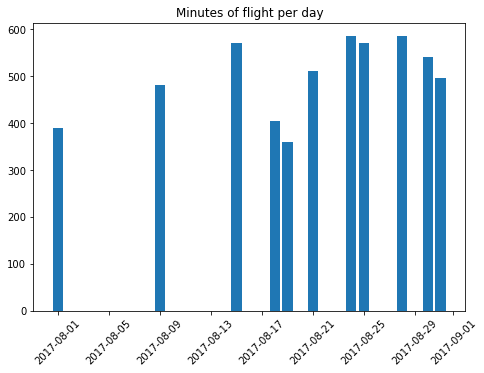

In [525]:
df = make_readable(evaluate_metrics(0, "2017-08-01T00:00:00.000", "2017-08-31T23:59:59.000", "MINUTE"))

bar_df = df.groupby('date', as_index=False).flight_now.sum()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(bar_df.date, bar_df.flight_now)
plt.xticks(rotation=45)
plt.title("Minutes of flight per day")
plt.show()

Dates in August which don't plot right: 9 August, 21 August, 24 August, 28 August, 30 August, 31 August

Other dates: 1 August, 15 August, 18 August, 19 August, 25 August

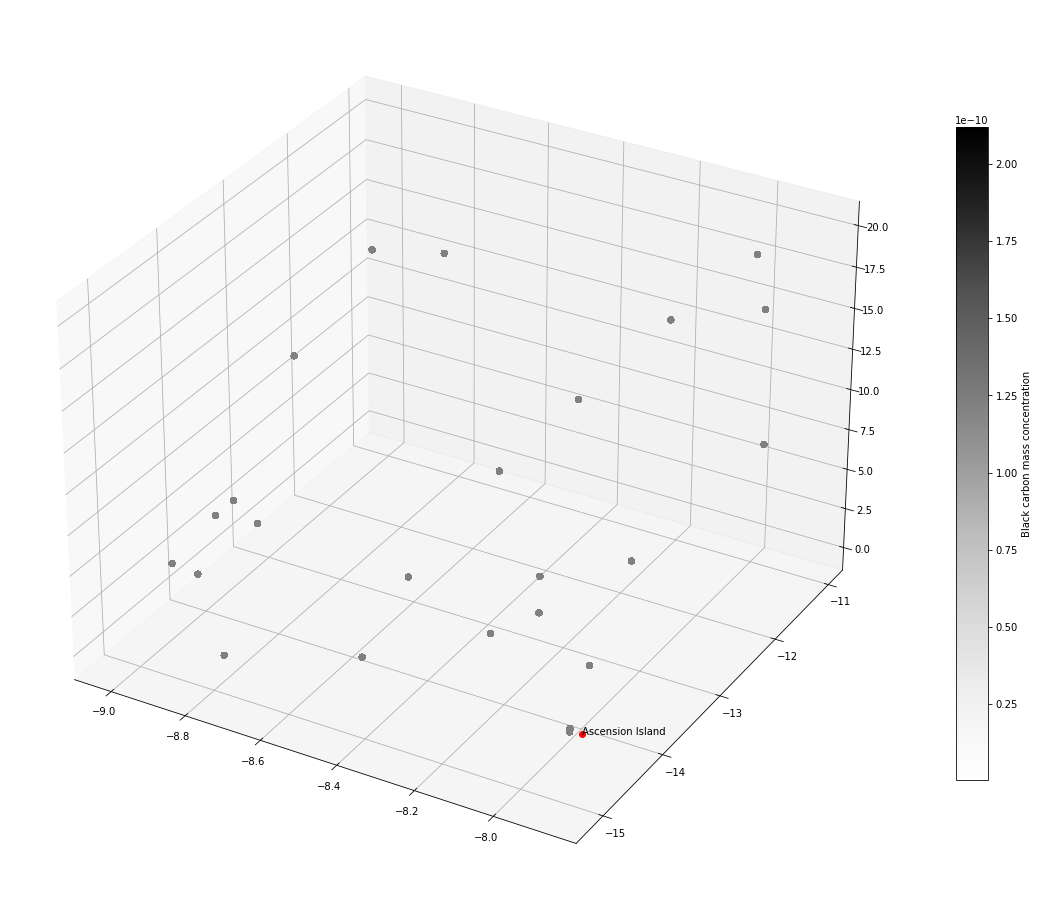

In [553]:
df = make_readable(evaluate_metrics(0, "2017-08-18T00:00:00.000", "2017-08-18T23:59:59.000", "SECOND"))

def plot_3d_sim_data(df, lon_adjust=360):
    path_df = df[df.AverageAlt_SimulationSample != 0][['AverageAlt_SimulationSample', 'AverageLat_SimulationSample', 'AverageLon_SimulationSample', 'timestamp', 'AverageMassBCacc_SimulationSample']]
    path_df.columns = ['alt', 'lat', 'lon', 'timestamp', 'bc']
    path_df['time'] = pd.to_datetime(path_df.timestamp).dt.second + 60*pd.to_datetime(path_df.timestamp).dt.minute + 360*pd.to_datetime(path_df.timestamp).dt.hour
    path_df['lon'] = path_df['lon'] - lon_adjust

    fig = plt.figure(figsize=[20, 20])
    ax = fig.add_subplot(projection='3d')

    scatter2 = ax.scatter(path_df.lat, path_df.lon, path_df.alt, alpha=1,
                         c=path_df.bc, cmap="Greys", s=path_df.bc)
    cbar = plt.colorbar(scatter2, shrink=0.6)
    cbar.set_label("Black carbon mass concentration")

    scatter = ax.scatter(path_df.lat, path_df.lon, path_df.alt, alpha=0.5, s=30,
                        c="Grey")

    ax.plot(-7.943368, -14.366035, 0, "ro")
    ax.text(-7.943368, -14.366035, 0, 'Ascension Island')

    plt.show()

plot_3d_sim_data(df)

## Example: Simulation for 18 August 2017

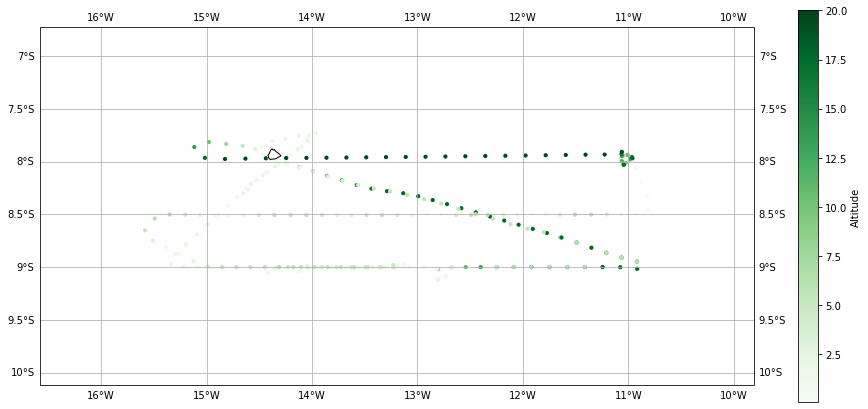

In [491]:
sample = c3.NetCDFUtil.openFile(file_name + '20170818.nc')
# To read the variable names in this file, print(sample.variables.keys())

# These are the spatial variables
spatial = pd.DataFrame({
    'lat' : sample["latitude"][:],
    'lon' : sample["longitude"][:],
    'alt' : sample["altitude"][:]},
    columns = ['lat', 'lon', 'alt']
)

# Define the figure size and shape
BBox = [spatial.lon.min()-1, spatial.lon.max()+1,      
         spatial.lat.min()-1, spatial.lat.max()+1]
projection = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[16, 12])

# Draw island
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.coastlines()

# Produce gridlines, coordinate labels
ax.set_extent(BBox, ccrs.PlateCarree())
ax.gridlines(draw_labels=True, crs=projection)

# Add points along flight path and color for altitude
scatter = ax.scatter(spatial.lon, spatial.lat, zorder=1, alpha=1,
                     c=spatial.alt, cmap="Greens", s=10)
cbar = plt.colorbar(scatter, shrink=0.6)
cbar.set_label("Altitude")


plt.show()

## Example: 28 August flight doesn't look right

This plot gives the shape of the flight on the longitude axis over time according to the simulation (1st) and to the actual flight data (2nd).

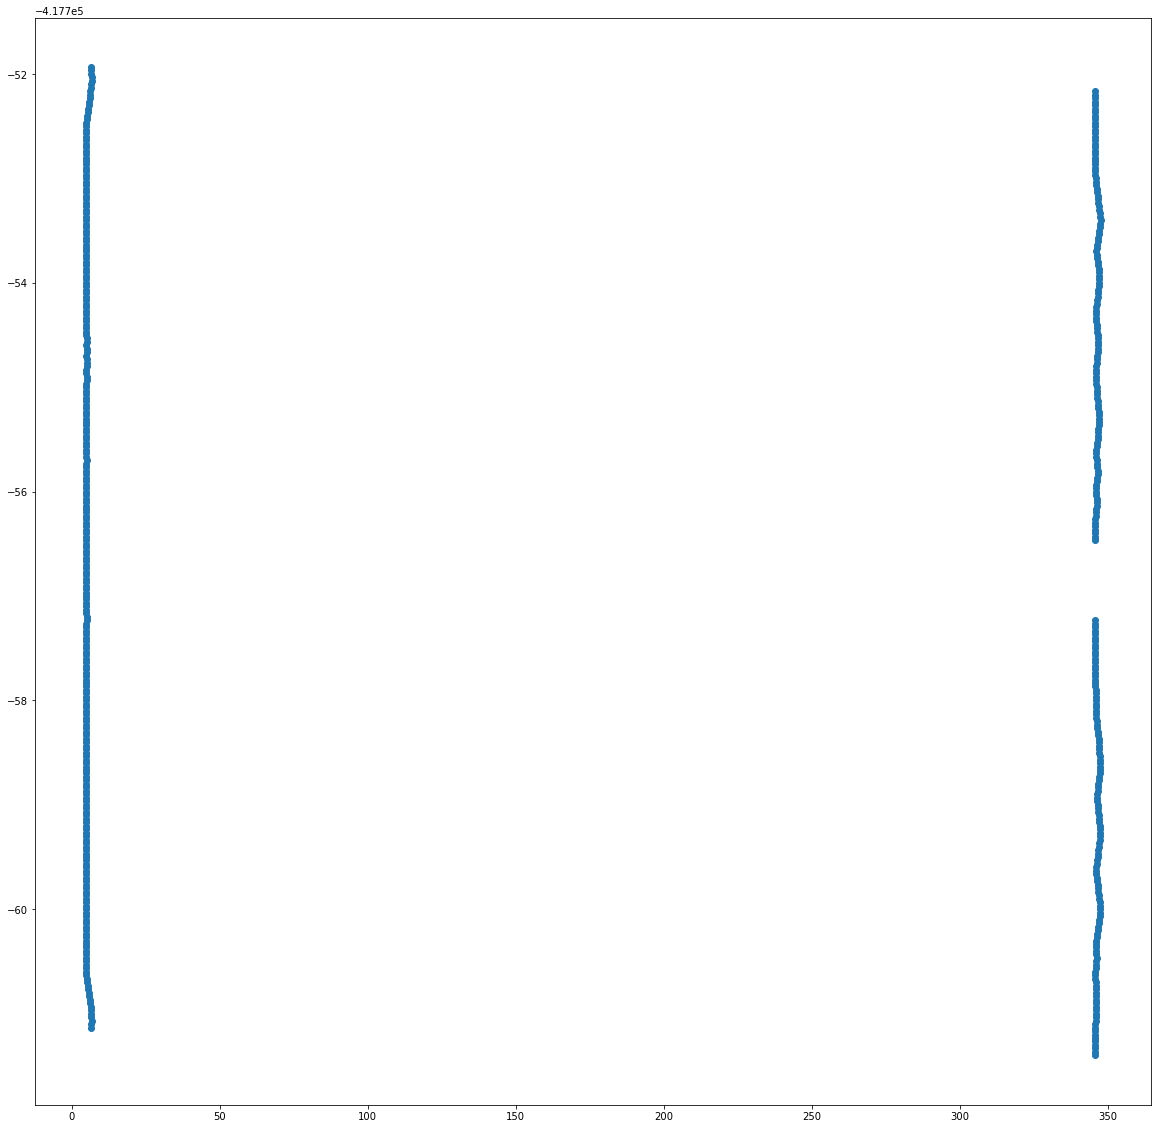

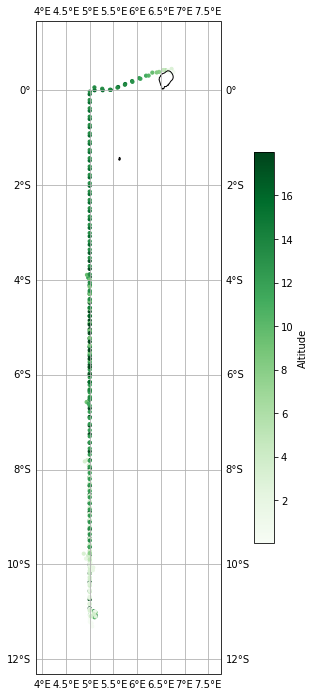

In [582]:
blob_root = 'https://devdtistore01.blob.core.windows.net/dev-dti/fs/dti/mpodolsky/gordon-group/'
file_path = 'acure_aircraft/u-bs714_ens000/'
file_name = blob_root + file_path + 'bs714a.flight_track_20170828.nc'

sample = c3.NetCDFUtil.openFile(file_name)

spatial = pd.DataFrame({
    'lat' : sample["latitude"][:],
    'lon' : sample["longitude"][:],
    'alt' : sample["altitude"][:],
    'time' : sample["time"][:]},
    columns = ['lat', 'lon', 'alt', 'time']
)

plt.figure(figsize=[20, 20])
plt.scatter(spatial.lon, -spatial.time)

spatial = spatial[spatial.lon < 180]

# Define the figure size and shape
BBox = [spatial.lon.min()-1, spatial.lon.max()+1,      
             spatial.lat.min()-1, spatial.lat.max()+1]
projection = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[12, 12])

    # Draw island
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.coastlines()

    # Produce gridlines, coordinate labels
ax.set_extent(BBox, ccrs.PlateCarree())
ax.gridlines(draw_labels=True, crs=projection)

    # Add points along flight path and color for altitude
scatter = ax.scatter(spatial.lon, spatial.lat, zorder=1, alpha=1,
                         c=spatial.alt, cmap="Greens", s=10)
cbar = plt.colorbar(scatter, shrink=0.6)
cbar.set_label("Altitude")

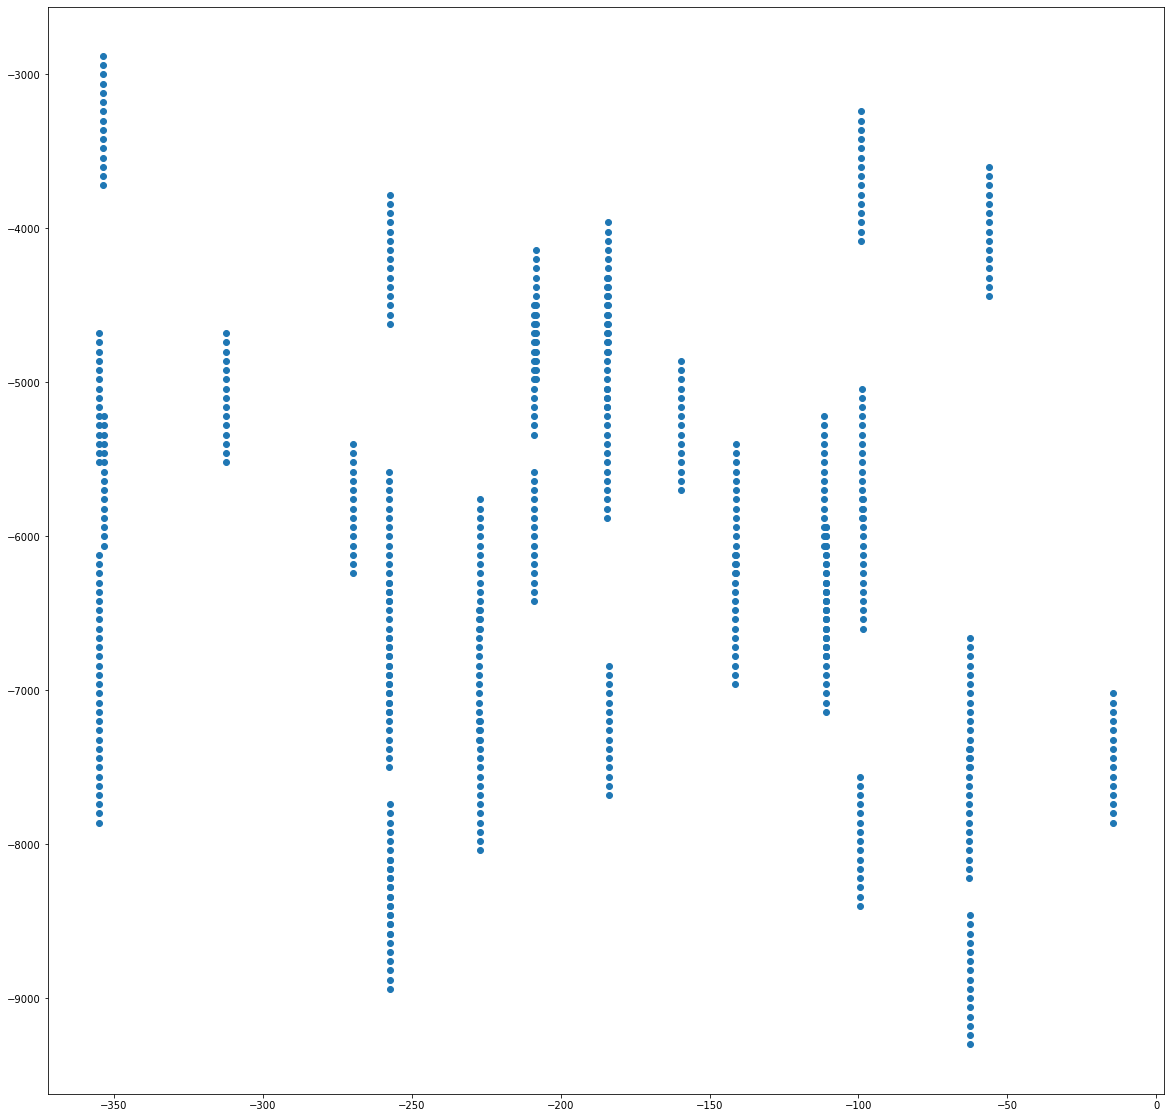

In [565]:
df = make_readable(evaluate_metrics(0, "2017-08-28T00:00:00.000", "2017-08-28T23:59:59.000", "MINUTE"))



path_df = df[df.AverageAlt_SimulationSample != 0][['AverageAlt_SimulationSample', 'AverageLat_SimulationSample', 'AverageLon_SimulationSample', 'timestamp']]
path_df.columns = ['alt', 'lat', 'lon', 'timestamp']
path_df['time'] = pd.to_datetime(path_df.timestamp).dt.second + 60*pd.to_datetime(path_df.timestamp).dt.minute + 360*pd.to_datetime(path_df.timestamp).dt.hour
path_df['lon'] = path_df['lon'] - 360

#print(path_df)

plt.figure(figsize=[20, 20])
plt.scatter(path_df.lon, -path_df.time)


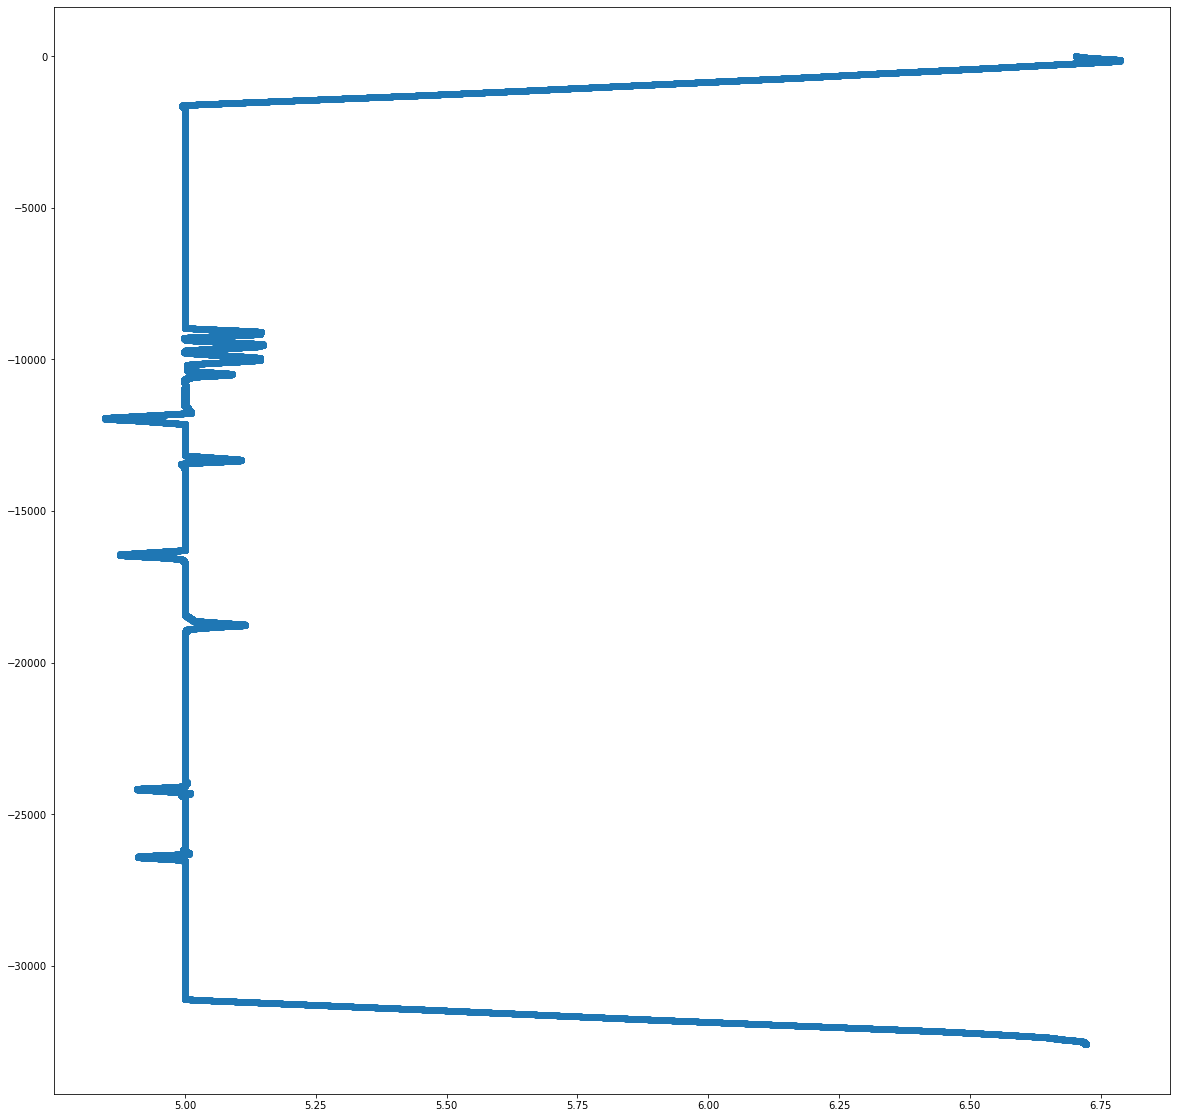

In [452]:
sample = c3.NetCDFUtil.openFile(obs_files_url[29])
# To read the variable names in this file, print(sample.variables.keys())

# These are the spatial variables
path_df = pd.DataFrame({
    'time' : np.linspace(1, 32591, 32591),
    'lat' : sample["Latitude"][:],
    'lon' : sample["Longitude"][:],
    'alt_gps' : sample["GPS_Altitude"][:],
    'alt_press' : sample["Pressure_Altitude"][:],
    'alt_radar' : sample["Radar_Altitude"][:]},
    columns = ['time', 'lat', 'lon', 'alt_gps', 'alt_press', 'alt_radar']
)

plt.figure(figsize=[20, 20])
plt.scatter(path_df.lon, -path_df.time)


[4.978815968086337, 345.55694696539933, -20.372424278222027, 10.378343913134763]


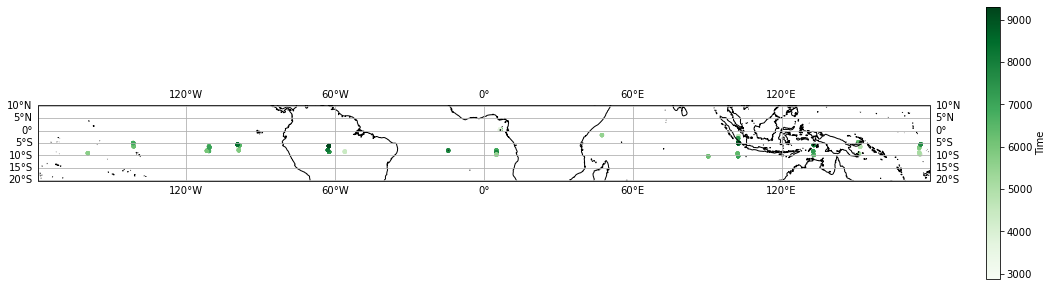

In [469]:
# path_df = path_df[(path_df.lon <= 330) & (path_df.lon >= 280)]

# Define the figure size and shape
BBox = [path_df.lon.min(), path_df.lon.max(),      
         path_df.lat.min()-10, path_df.lat.max()+10]
print(BBox)
projection = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[20,10])

# Draw island
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.coastlines()

# Produce gridlines, coordinate labels
ax.set_extent(BBox, ccrs.PlateCarree())
ax.gridlines(draw_labels=True, crs=projection)

# Add points along flight path and color for altitude
scatter = ax.scatter(path_df.lon, path_df.lat, zorder=1, alpha=1,
                     c=path_df.time, cmap="Greens", s=10)
cbar = plt.colorbar(scatter, shrink=0.5)
cbar.set_label("Time")

plt.show()

# Relating these two

Obviously all of the data files, observational and simulated, have spatiotemporal information and can be compared directly with these.

Other variables which are interesting to compare (observational / simulated):

rBC_massConc / ?


## Variables shared between all observation files

In [544]:
sample_first = c3.NetCDFUtil.openFile(obs_files_url[16])
vars_list = list(sample_first.variables.keys())

for i in [16, 22, 24, 25, 28]:
    next_sample = c3.NetCDFUtil.openFile(obs_files_url[i])
    
    vars_list = np.intersect1d(vars_list,
                               list(next_sample.variables.keys()))

print(vars_list)

['AOD' 'AOD_angstrom_470_865' 'AOD_polycoef_a0' 'AOD_polycoef_a1'
 'AOD_polycoef_a2' 'AODwavelength' 'Aircraft_Sun_Azimuth'
 'Aircraft_Sun_Elevation' 'CASConcCH' 'CASMeanVol' 'CASNtCloud' 'CAS_Conc'
 'CAS_EffRad' 'CAS_LWC' 'CAS_Mean' 'CAS_Median' 'CAS_NtAero' 'CAS_NtConc'
 'CASdiameter' 'CASdiameters' 'CIP_PPress' 'CIP_SPress' 'CIP_TAS' 'COD'
 'COD_err' 'CWV' 'Cabin_Pressure' 'Day_Of_Year' 'Dew_Point' 'Drift_Angle'
 'GPS_Altitude' 'Ground_Speed' 'HVPS3HMdVol' 'HVPS3H_CH' 'HVPS3H_Eff'
 'HVPS3H_Mean' 'HVPS3H_Med' 'HVPS3diameter' 'HVPS3diameters'
 'IR_Surf_Temp' 'Indicated_Air_Speed' 'King_LWC_ad' 'LWP' 'LWP_err'
 'Latitude' 'Longitude' 'Mach_Number' 'Mixing_Ratio' 'NtHVPS3H1MM'
 'Nt_HVPS3H' 'Part_Press_Water_Vapor' 'Pitch_Angle' 'Potential_Temp'
 'Pressure_Altitude' 'QA_CWV' 'QA_HCOH' 'QA_NO2' 'QA_O3' 'REF' 'REF_err'
 'Radar_Altitude' 'Relative_Humidity' 'Roll_Angle' 'SPP200Aflow'
 'SPP200EffRa' 'SPP200Lflow' 'SPP200MeanR' 'SPP200SupTo' 'SPP200TIMVC'
 'SPP200TotIn' 'SPP200Total' 'SPP200_

## All flights

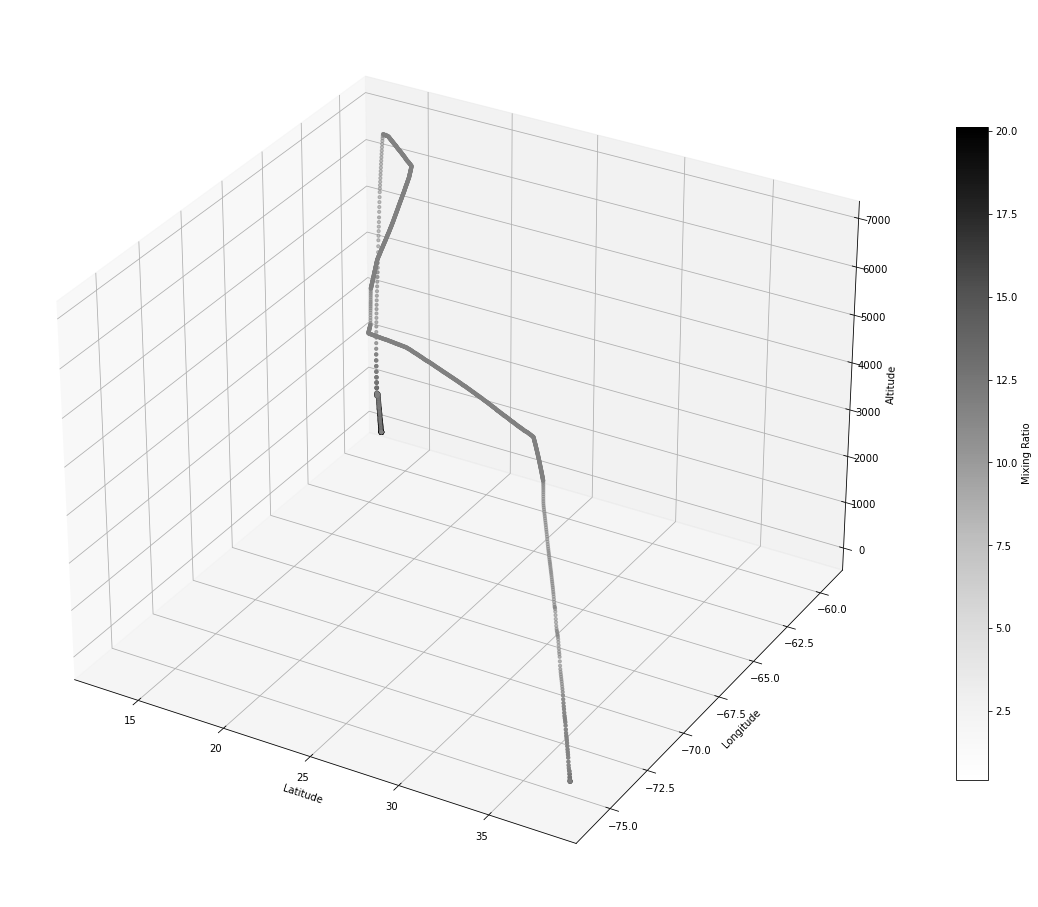

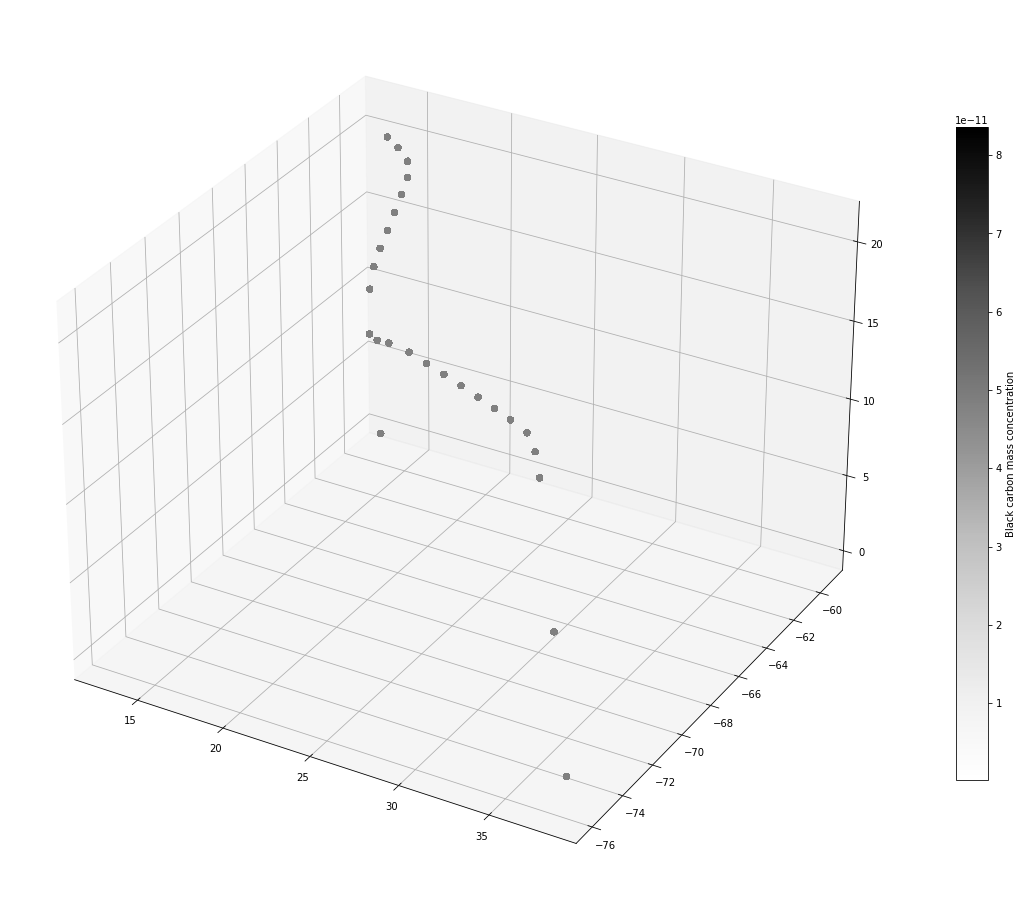

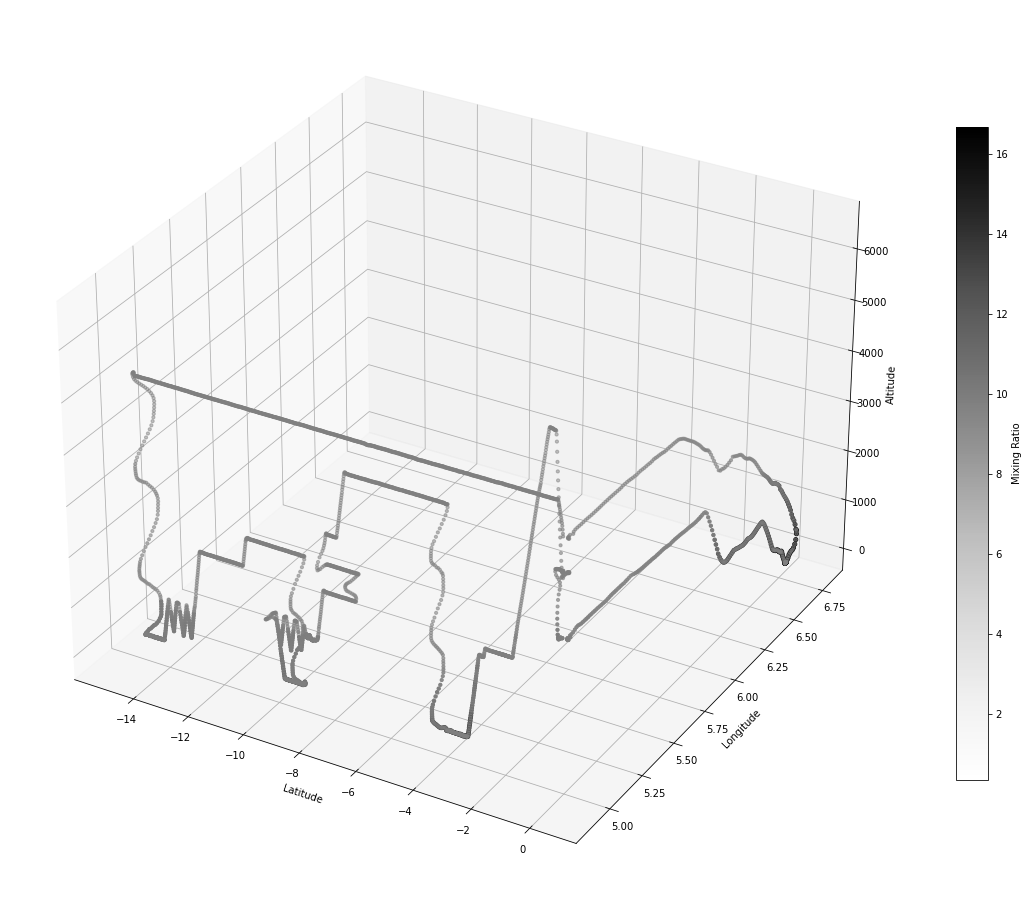

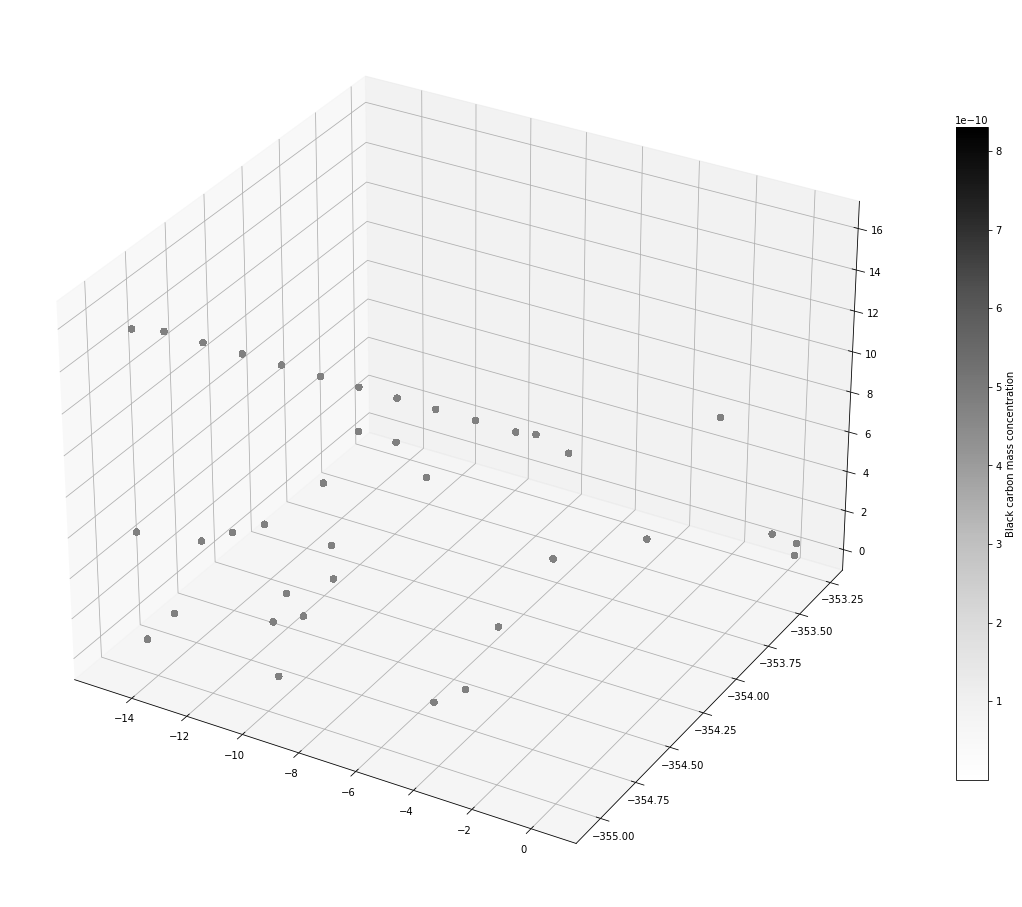

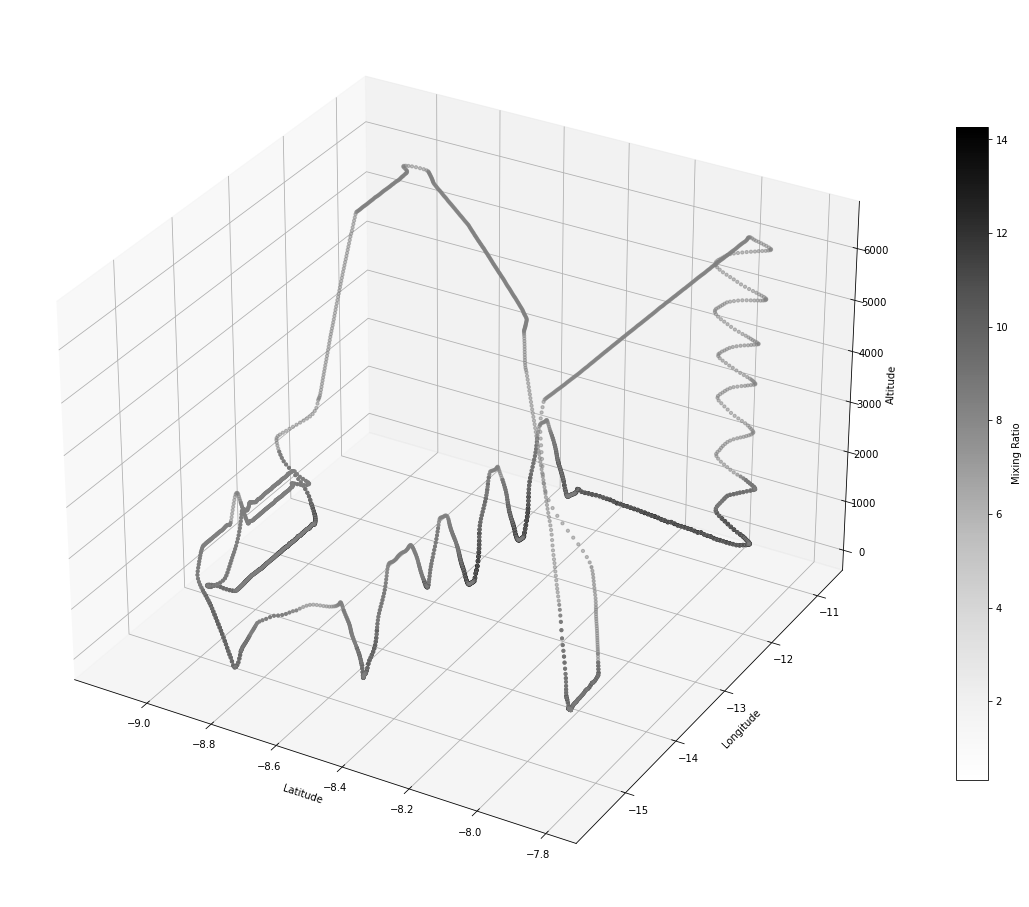

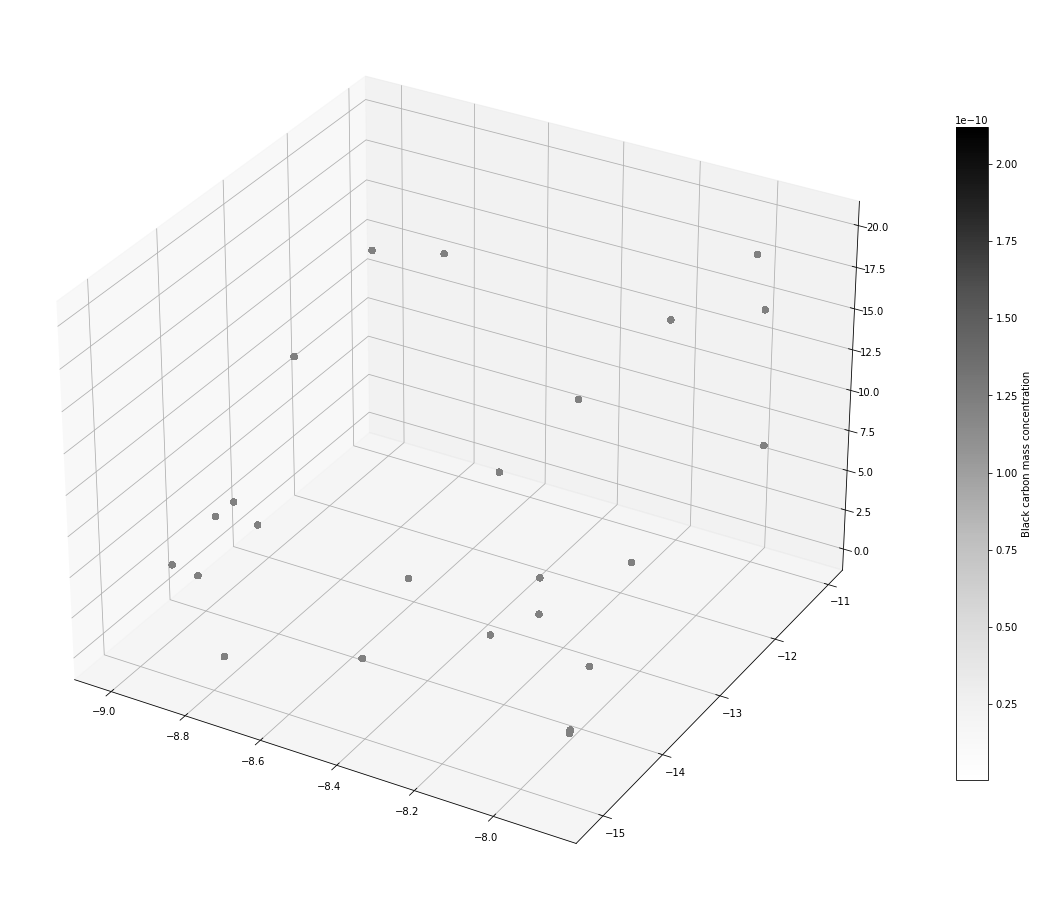

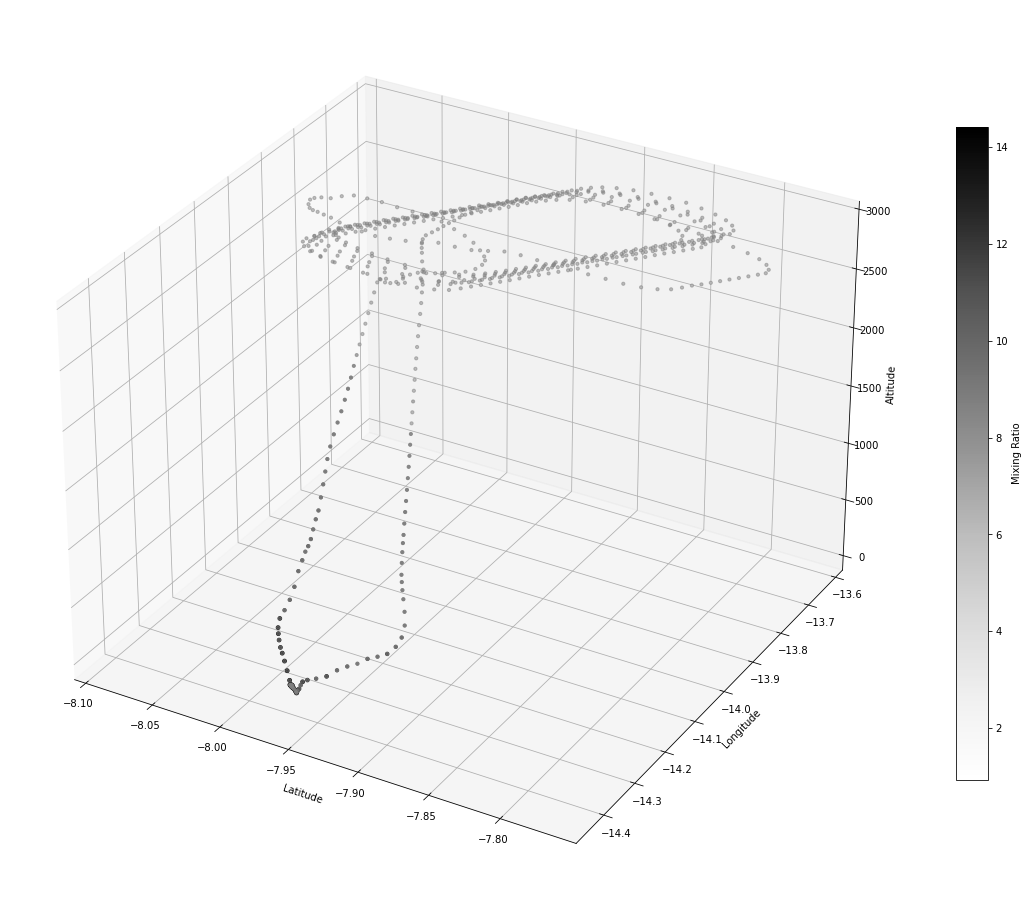

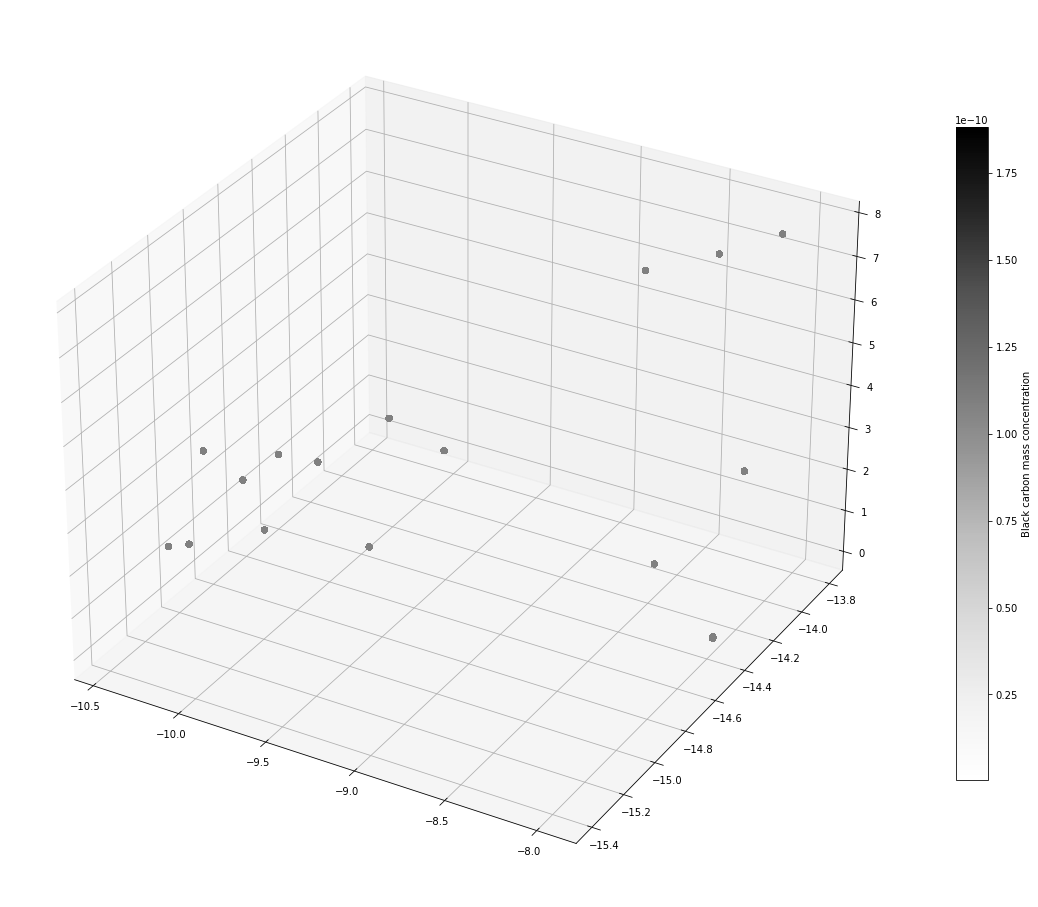

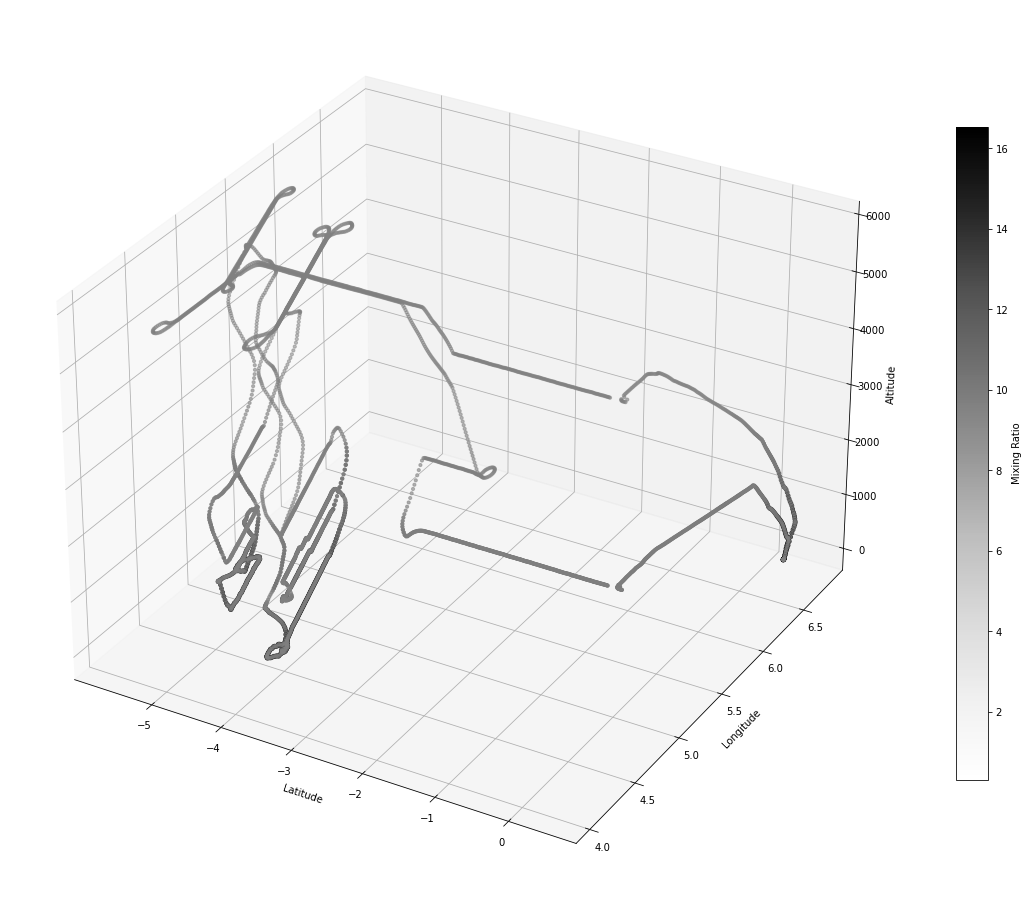

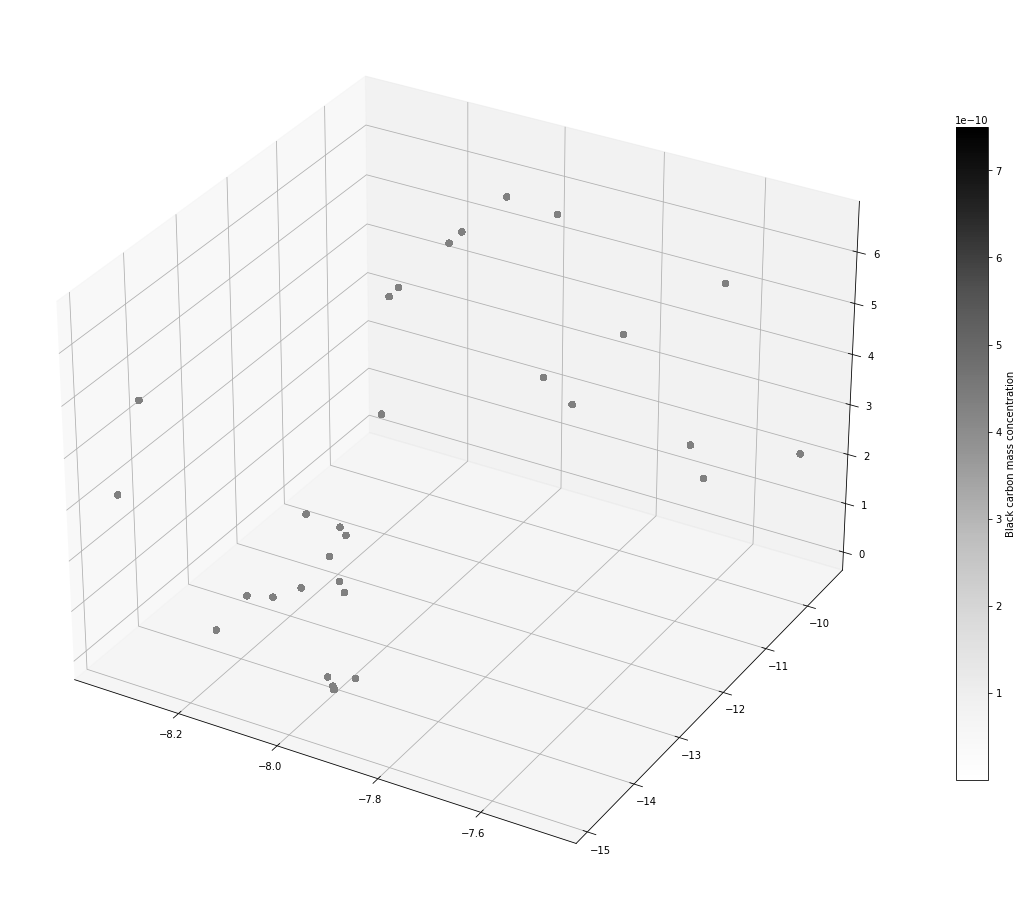

In [558]:
def plot_obs_flight_3d(url_index, rows_to_skip):
    """
    Parameters
    
    url_index : integer, 0 to 34
        Which flight to plot - 0-15 are R18, 16-34 are R26
    rows_to_skip : integer
        If rows_to_skip = N, only plot every Nth point in the flight
    """
    sample = c3.NetCDFUtil.openFile(obs_files_url[url_index])
    # To read the variable names in this file, print(sample.variables.keys())

    # These are the spatial variables
    spatial = pd.DataFrame({
        'lat' : sample["Latitude"][:],
        'lon' : sample["Longitude"][:],
        'alt_gps' : sample["GPS_Altitude"][:],
        'alt_press' : sample["Pressure_Altitude"][:],
        'alt_radar' : sample["Radar_Altitude"][:],
        'mr' : sample["Mixing_Ratio"][:]},
        columns = ['lat', 'lon', 'alt_gps', 'alt_press', 'alt_radar', 'mr']
    )

    fig = plt.figure(figsize=[20, 20])
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    scatter2 = ax.scatter(spatial.lat[::rows_to_skip], spatial.lon[::rows_to_skip], spatial.alt_gps[::rows_to_skip], alpha=1,
                         c=spatial.mr[::rows_to_skip], cmap="Greys", s=spatial.mr[::rows_to_skip])
    cbar = plt.colorbar(scatter2, shrink=0.6)
    cbar.set_label("Mixing Ratio")
    # cbar.set_label("SPP200_CH")
    scatter = ax.scatter(spatial.lat[::rows_to_skip], spatial.lon[::rows_to_skip], spatial.alt_gps[::rows_to_skip], alpha=0.5, s=10,
                        c="Grey")
    plt.show()

def plot_sim_flight_3d(df, lon_adjust=360):
    path_df = df[df.AverageAlt_SimulationSample != 0][['AverageAlt_SimulationSample', 'AverageLat_SimulationSample', 'AverageLon_SimulationSample', 'timestamp', 'AverageMassBCacc_SimulationSample']]
    path_df.columns = ['alt', 'lat', 'lon', 'timestamp', 'bc']
    path_df['time'] = pd.to_datetime(path_df.timestamp).dt.second + 60*pd.to_datetime(path_df.timestamp).dt.minute + 360*pd.to_datetime(path_df.timestamp).dt.hour
    path_df['lon'] = path_df['lon'] - lon_adjust

    fig = plt.figure(figsize=[20, 20])
    ax = fig.add_subplot(projection='3d')

    scatter2 = ax.scatter(path_df.lat, path_df.lon, path_df.alt, alpha=1,
                         c=path_df.bc, cmap="Greys", s=path_df.bc)
    cbar = plt.colorbar(scatter2, shrink=0.6)
    cbar.set_label("Black carbon mass concentration")

    scatter = ax.scatter(path_df.lat, path_df.lon, path_df.alt, alpha=0.5, s=30,
                        c="Grey")

    plt.show()

# 1 August
plot_obs_flight_3d(16, 10)
plot_sim_flight_3d(make_readable(evaluate_metrics(0, "2017-08-01T00:00:00.000", "2017-08-01T23:59:59.000", "SECOND")))

# 15 August
plot_obs_flight_3d(22, 10)
plot_sim_flight_3d(make_readable(evaluate_metrics(0, "2017-08-15T00:00:00.000", "2017-08-15T23:59:59.000", "SECOND")))

# 18 August
plot_obs_flight_3d(24, 10)
plot_sim_flight_3d(make_readable(evaluate_metrics(0, "2017-08-18T00:00:00.000", "2017-08-18T23:59:59.000", "SECOND")))


# 19 August
plot_obs_flight_3d(25, 10)
plot_sim_flight_3d(make_readable(evaluate_metrics(0, "2017-08-19T00:00:00.000", "2017-08-19T23:59:59.000", "SECOND")))

# 25 August
# No obs file? Here's the one on 26 August
plot_obs_flight_3d(28, 10)
plot_sim_flight_3d(make_readable(evaluate_metrics(0, "2017-08-25T00:00:00.000", "2017-08-25T23:59:59.000", "SECOND")))